In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow

from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.losses import categorical_crossentropy
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay

colab = False  # Type True if using Google Colab, type False if using Jupyter Notebook
if colab:
    from google.colab import drive
    from zipfile import ZipFile

tensorflow.random.set_seed(42)

In [3]:
# Mounting Google Drive for use with Google Colab
if colab:
    drive.mount('/content/drive', force_remount=True)

In [4]:
# Creating file paths for use with Google Colab
if colab:
    train_features_path = 'drive/MyDrive/group_project_data/Train-Features/train_features copy.csv'
    train_labels_path = 'drive/MyDrive/group_project_data/Train-Label/train_labels copy.csv'
    test_features_path = 'drive/MyDrive/group_project_data/Test-Features/test_features copy.csv'
    train_images_path = 'drive/MyDrive/group_project_data/Train-Images/train_features.zip'
    test_images_path = 'drive/MyDrive/group_project_data/Test-Images/test_features.zip'
    submission_format_path = 'drive/MyDrive/group_project_data/Submission-Format/submission_format.csv'


    with ZipFile(train_images_path, 'r') as train_zip:
        train_zip.extractall()
        print('Unzipped Train Images file')

    with ZipFile(test_images_path, 'r') as test_zip:
        test_zip.extractall()
        print('Unzipped Test Images file')

In [6]:
# Creating DataFrames from csv files
if colab:
    train_features = pd.read_csv(train_features_path)
    train_labels = pd.read_csv(train_labels_path)
    test_features = pd.read_csv(test_features_path)
    submission_format = pd.read_csv(submission_format_path)

else:
    train_features = pd.read_csv('../data/train_features.csv')
    train_labels = pd.read_csv('../data/train_labels.csv')
    test_features = pd.read_csv('../data/test_features.csv')
    submission_format = pd.read_csv('../data/submission_format.csv')

In [7]:
train_features

,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
1,ZJ000001,train_features/ZJ000001.jpg,S0069
2,ZJ000002,train_features/ZJ000002.jpg,S0009
3,ZJ000003,train_features/ZJ000003.jpg,S0008
4,ZJ000004,train_features/ZJ000004.jpg,S0036
...,...,...,...
16483,ZJ016483,train_features/ZJ016483.jpg,S0093
16484,ZJ016484,train_features/ZJ016484.jpg,S0043
16485,ZJ016485,train_features/ZJ016485.jpg,S0089
16486,ZJ016486,train_features/ZJ016486.jpg,S0095


In [8]:
def merge_animals(df):
    """_summary_

    Args:
        df (_type_): _description_

    Returns:
        _type_: _description_
    """
    df_copy = df.copy() # copy df
    columns = df_copy.columns # get column names
    df_copy['animal_classification'] = np.where(df_copy.values)[1]+1 # add a numeric value to each column
    df_copy.drop(columns ,axis=1, inplace=True) # drop columns that were just combined
    return df_copy
#                ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
# Classification:           1           2        3           4          5        6              7               8

In [13]:
# combine train df's on id
train = pd.merge(left=train_features, right=train_labels, on='id') 

# see function in above cell
train['animal_classification'] = merge_animals(train[['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']]) 
# done in function above ^ might need 
# train.drop(['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent'] ,axis=1, inplace=True) # drop

# rename numeric observations to actual classifications
train['animal_classification'] = train['animal_classification'].map({1:'antelope_duiker', 2:'bird', 3:'blank', 4:'civet_genet', 5:'hog', 6:'leopard', 7:'monkey_prosimian', 8:'rodent'})

# split file path column to get file names
temp = train['filepath'].str.split(pat='/',expand=True)
# rename split columns
temp.rename(columns={0: 'old_folder_location', 1: 'filename'}, inplace=True)

# concat columns and original df
train = pd.concat([train, temp], axis=1).drop(columns=['filepath'],axis=1)

# same for test (holdout set for predictions)
temp2 = test_features['filepath'].str.split(pat='/', expand=True)
temp2.rename(columns={0: 'old_folder_location', 1: 'filename'}, inplace=True) # rename split columns
test = pd.concat([test_features, temp2], axis=1).drop(columns=['filepath'],axis=1) # concat columns


In [10]:
# make validation set
validation_set = train[(train['site']=='S0009') | (train['site']=='S0043')| (train['site']=='S0059') |(train['site']== 'S0026')] # get validation set for 2 sites
# make training set
train_set = train[~train.isin(validation_set)].dropna() # remove the observations from train that are in the validation set

In [11]:
validation_set['animal_classification'].value_counts(normalize=True)

monkey_prosimian    0.187879
leopard             0.168485
rodent              0.146667
bird                0.142424
civet_genet         0.122424
hog                 0.113939
antelope_duiker     0.064848
blank               0.053333
Name: animal_classification, dtype: float64

In [12]:
train_images = '/content/train_features'
test_images = '/content/test_features'

In [14]:
# Creating an ImageDataGenerator
if colab:
    img_gen = ImageDataGenerator(brightness_range=[0.2,1.0])
    val_generator = img_gen.flow_from_dataframe(
        validation_set, 
        directory=train_images, 
        x_col='filename', 
        y_col='animal_classification', 
        target_size=(256, 256), 
        class_mode='categorical',
        batch_size=32
)
    train_generator = img_gen.flow_from_dataframe(
        train_set, 
        directory=train_images, 
        x_col='filename', 
        y_col='animal_classification', 
        target_size=(256, 256), 
        class_mode='categorical',
        batch_size=64
)
else:
    img_gen = ImageDataGenerator()
    val_generator = img_gen.flow_from_dataframe(
        validation_set, 
        directory='../data/train_features_img', 
        x_col='filename', 
        y_col='animal_classification', 
        target_size=(256, 256), 
        class_mode='categorical',
        batch_size=32
)
    train_generator = img_gen.flow_from_dataframe(
        train_set, 
        directory='../data/train_features_img', 
        x_col='filename', 
        y_col='animal_classification', 
        target_size=(256, 256), 
        class_mode='categorical',
        batch_size=64
)
    # holdout set
    test_generator = img_gen.flow_from_dataframe(
    test,
    directory='../data/test_features_img',
    x_col='filename',
    class_mode=None,
    target_size=(256, 256)
)   

Found 1650 validated image filenames belonging to 8 classes.
Found 14838 validated image filenames belonging to 8 classes.
Found 4464 validated image filenames.


In [24]:
def plot_metrics(model_fit, save_plots=False):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    titles = ['Loss Optimization', 'Categorical Accuracy Performance', 'Precision Performance', 'Recall Performance']
    for j, i in enumerate(metrics):
        plt.plot(model_fit.history[i], label='Train')
        plt.plot(model_fit.history[f'val_{i}'], label='Test')
        plt.ylabel(i)
        plt.xlabel('epochs')
        plt.title(titles[j])
        plt.legend()
        plt.show()
        if save_plots:
            plt.savefig(f'../images/{titles[j]}.png')

In [15]:
effnet = EfficientNetB0(include_top=False, weights='imagenet')
effnet.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [16]:
model_es = Sequential()
model_es.add(effnet)
model_es.add(GlobalAveragePooling2D())
model_es.add(Dense(8, activation='softmax'))

In [17]:
model_es.compile(optimizer=Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

In [18]:
early_stop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1)

In [19]:
history_es = model_es.fit(
    train_generator,
    batch_size=64,
    epochs=50,
    validation_data=val_generator,
    callbacks = [early_stop]
)

Epoch 1/50
232/232 [==============================] - 372s 2s/step - loss: 1.8434 - accuracy: 0.3008 - recall: 0.0220 - precision: 0.9134 - val_loss: 1.7607 - val_accuracy: 0.3564 - val_recall: 0.0867 - val_precision: 0.5586
Epoch 2/50
232/232 [==============================] - 362s 2s/step - loss: 1.5536 - accuracy: 0.4409 - recall: 0.0916 - precision: 0.8574 - val_loss: 1.6114 - val_accuracy: 0.4067 - val_recall: 0.1364 - val_precision: 0.6410
Epoch 3/50
232/232 [==============================] - 364s 2s/step - loss: 1.4263 - accuracy: 0.4908 - recall: 0.1518 - precision: 0.8702 - val_loss: 1.5333 - val_accuracy: 0.4442 - val_recall: 0.1661 - val_precision: 0.6799
Epoch 4/50
232/232 [==============================] - 362s 2s/step - loss: 1.3490 - accuracy: 0.5179 - recall: 0.1859 - precision: 0.8678 - val_loss: 1.4942 - val_accuracy: 0.4552 - val_recall: 0.1885 - val_precision: 0.6776
Epoch 5/50
232/232 [==============================] - 361s 2s/step - loss: 1.2941 - accuracy: 0.5344

In [5]:
# exporting model - uncomment to run
# model_es.save('../model_data/')

# older save export format H5 - uncomment to run
# model_es.save('../model_data_h5/model_es.h5', save_format='h5')

In [35]:
# loading model - uncomment to run
# model_es = load_model('../model_data')
model_es.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
Total params: 4,059,819
Trainable params: 10,248
Non-trainable params: 4,049,571
_________________________________________________________________


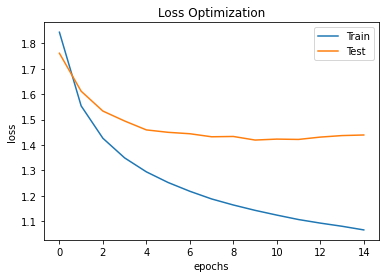

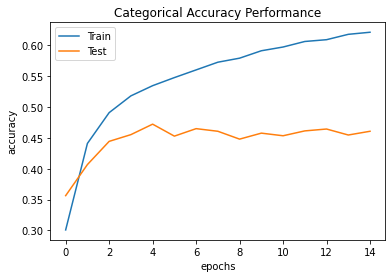

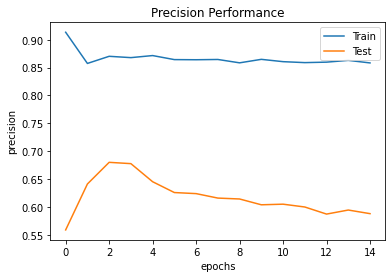

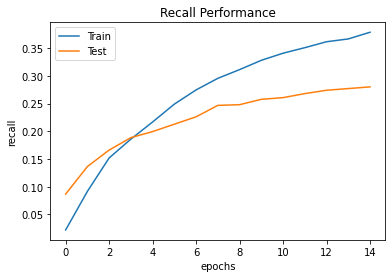

In [25]:
plot_metrics(history_es)

## Predictions

In [36]:
# generating soft predictions (returns probabilities)
val_preds = model_es.predict(val_generator)
print(val_preds.shape)
val_preds

(1650, 8)


array([[0.11016661, 0.00624187, 0.15342206, ..., 0.00304733, 0.03575931,
        0.32890397],
       [0.06397065, 0.3240486 , 0.08347738, ..., 0.38130817, 0.06636874,
        0.04682937],
       [0.05286231, 0.01467638, 0.15403852, ..., 0.44324452, 0.00565845,
        0.12055051],
       ...,
       [0.14480616, 0.18024465, 0.15301281, ..., 0.1168363 , 0.17650628,
        0.19958296],
       [0.01335874, 0.13245545, 0.01679655, ..., 0.80391353, 0.01429931,
        0.00976451],
       [0.07387961, 0.05153065, 0.6376403 , ..., 0.07487133, 0.08017377,
        0.05393216]], dtype=float32)

In [37]:
# converting to hard predictions
val_preds_class = np.array([np.where(array == array.max(), 1, 0) for array in val_preds]) #highest probability yields true for that class
print(val_preds_class.shape)
val_preds_class

(1650, 8)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [38]:
# flattening to 1D array for confusion matrix
val_preds_class_1D = np.array([np.argmax(row) for row in val_preds_class])
print(val_preds_class_1D.shape)
val_preds_class_1D

(1650,)


array([3, 5, 5, ..., 7, 5, 2], dtype=int64)

## Evaluation

In [39]:
# gathering true image labels to compare to predicted labels
val_labels = np.array(val_generator.classes)
print(val_labels.shape)
val_labels

(1650,)


array([1, 1, 3, ..., 3, 6, 5])

In [40]:
# recall the label,index pairing
label_names = list(train_generator.class_indices.keys()) #will use for confusion matrix
train_generator.class_indices

{'antelope_duiker': 0,
 'bird': 1,
 'blank': 2,
 'civet_genet': 3,
 'hog': 4,
 'leopard': 5,
 'monkey_prosimian': 6,
 'rodent': 7}

In [41]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [42]:
print(classification_report(val_labels, val_preds_class_1D, target_names=label_names))

                  precision    recall  f1-score   support

 antelope_duiker       0.09      0.12      0.11       107
            bird       0.13      0.14      0.13       235
           blank       0.08      0.10      0.09        88
     civet_genet       0.14      0.24      0.17       202
             hog       0.12      0.02      0.03       188
         leopard       0.16      0.19      0.17       278
monkey_prosimian       0.23      0.19      0.21       310
          rodent       0.18      0.14      0.16       242

        accuracy                           0.15      1650
       macro avg       0.14      0.14      0.13      1650
    weighted avg       0.16      0.15      0.15      1650



In [43]:
multi_confmatrix = {label_names[i]:matrix for i, matrix in enumerate(multilabel_confusion_matrix(val_labels, val_preds_class_1D))}
multi_confmatrix

{'antelope_duiker': array([[1419,  124],
        [  94,   13]], dtype=int64),
 'bird': array([[1198,  217],
        [ 203,   32]], dtype=int64),
 'blank': array([[1456,  106],
        [  79,    9]], dtype=int64),
 'civet_genet': array([[1145,  303],
        [ 154,   48]], dtype=int64),
 'hog': array([[1440,   22],
        [ 185,    3]], dtype=int64),
 'leopard': array([[1091,  281],
        [ 226,   52]], dtype=int64),
 'monkey_prosimian': array([[1146,  194],
        [ 251,   59]], dtype=int64),
 'rodent': array([[1255,  153],
        [ 208,   34]], dtype=int64)}

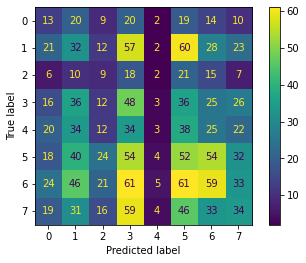

In [44]:
ConfusionMatrixDisplay.from_predictions(val_labels, val_preds_class_1D)
#plt.savefig('../images/multi_confusion_matrix.png')

### Example: Predicting image class

In this section we use our classification model to generate a class prediction on a single image.

In [190]:
sample_batch = val_generator.next() #gather image batch; default batch_size = 32

# first index are images, and second index are image labels
print(sample_batch[0].shape, sample_batch[1].shape)

(32, 256, 256, 3) (32, 8)


In [276]:
# extracting single image from batch
sample_img = sample_batch[0][0]
sample_img.shape

(256, 256, 3)

We can now render this image using matplotlib.

Text(0.5, 1.0, 'bird')

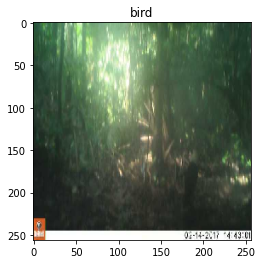

In [278]:
# rendering image
plt.imshow(sample_img/255)

# Actual image label
plt.title(f'{label_names[np.argmax(sample_batch[1][0])]}') #recall we can access labels from batch

Recall all our image labels

In [279]:
label_names

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

To predict the class, our image dimensions need to be expanded from (256, 256, 3) -> (1, 256, 256, 3) to fulfill model input format.

In [280]:
# image dimensions expansion
sample_img_expanded = np.expand_dims(sample_img/255, axis=0) #also scaling down our pixel values to range (0, 1)
sample_img_expanded.shape

(1, 256, 256, 3)

In [281]:
# Now we can generate a class prediction for this image
sample_prob = model_es.predict(sample_img_expanded)
sample_prob #output is an array of class probabilities

array([[0.1378878 , 0.08993447, 0.18383282, 0.12066754, 0.13335526,
        0.10621435, 0.14229956, 0.08580822]], dtype=float32)

In [282]:
# recall that the highest probability becomes the predicted class
np.where(sample_prob == sample_prob.max(), 1, 0)

array([[0, 0, 1, 0, 0, 0, 0, 0]])

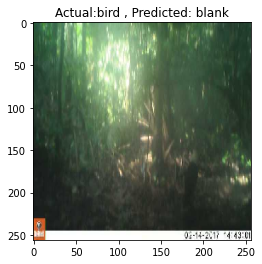

In [284]:
# We can now assign a predicted label to our input image
plt.imshow(sample_img/255)
plt.title(f'Actual:{label_names[np.argmax(sample_batch[1][0])]} , Predicted: {label_names[np.argmax(sample_prob)]}');